<a href="https://colab.research.google.com/github/vivekkuamar-dudhat/machine-learning/blob/main/Machine_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from google.colab import drive
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')


# ---- Load Dataset ----
df = pd.read_csv("/content/Fragrance Dataset .csv")
print(" Dataset Loaded Successfully")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dataset Loaded Successfully
Shape: (1000, 10)

Columns:
 ['brand', 'title', 'type', 'price', 'priceWithCurrency', 'available', 'availableText', 'sold', 'lastUpdated', 'itemLocation']


In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna("Unknown", inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# Drop columns with very little variation (e.g. unique in all rows)
low_var_cols = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=low_var_cols, inplace=True, errors='ignore')

print("\nDropped low-variance columns:", low_var_cols)

# Identify categorical and numeric features
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=[np.number]).columns

print("\nCategorical Columns:", list(cat_cols))
print("Numeric Columns:", list(num_cols))

# Encode categorical columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

print("\n Data Preprocessing Completed Successfully")



Dropped low-variance columns: []

Categorical Columns: []
Numeric Columns: ['brand', 'title', 'type', 'price', 'priceWithCurrency', 'available', 'availableText', 'sold', 'lastUpdated', 'itemLocation']

 Data Preprocessing Completed Successfully



===== BASIC DATA INSIGHTS =====
             brand        title        type        price  priceWithCurrency  \
count  1000.000000  1000.000000  1000.00000  1000.000000        1000.000000   
mean    122.662000   483.439000    29.27100    46.497279         343.218000   
std      73.843176   280.073178     9.11354    35.519540         191.887538   
min       0.000000     0.000000     0.00000     3.000000           0.000000   
25%      58.000000   242.750000    25.00000    22.990000         175.750000   
50%     114.500000   482.500000    29.00000    35.990000         350.000000   
75%     195.000000   726.250000    29.00000    59.000000         495.250000   
max     246.000000   965.000000    63.00000   259.090000         684.000000   

         available  availableText          sold  lastUpdated  itemLocation  \
count  1000.000000    1000.000000   1000.000000  1000.000000   1000.000000   
mean     20.046119     388.628000    766.266600   494.395000    111.562000   
std      58.027996   

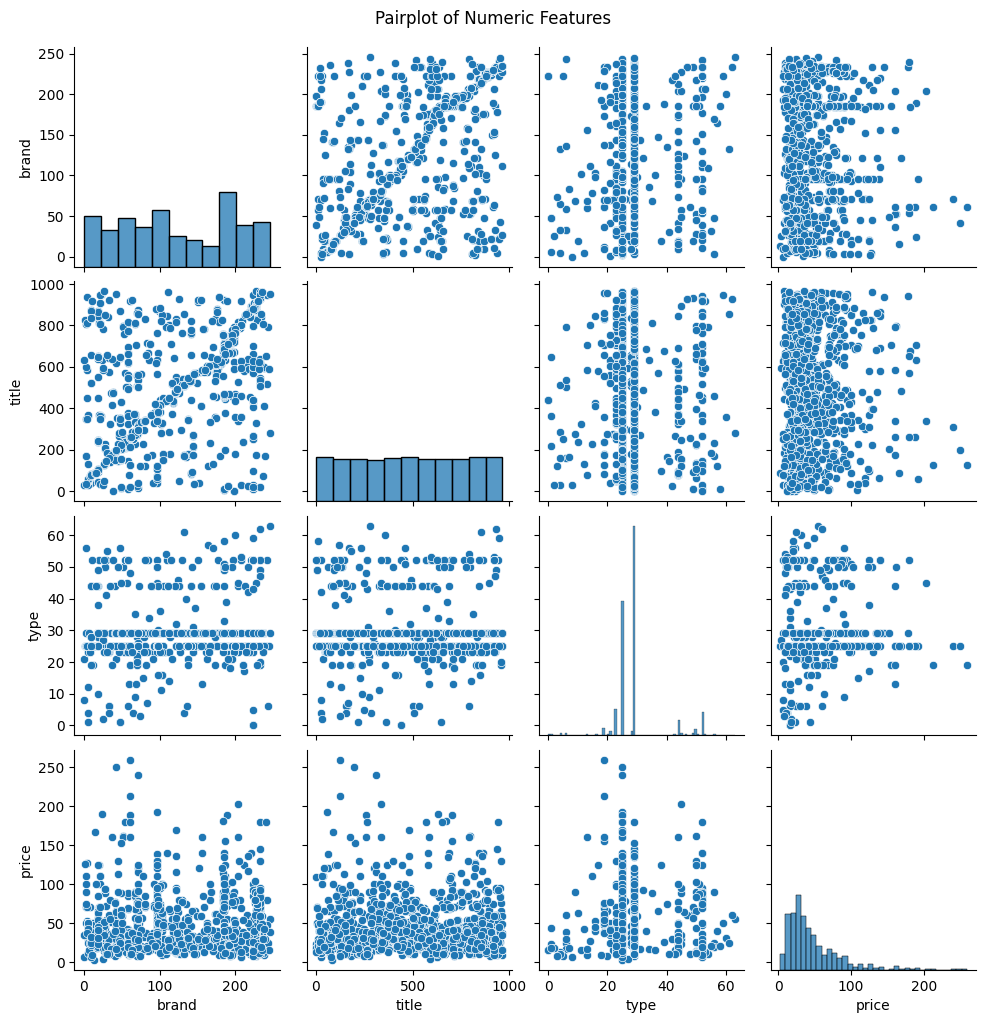

In [ ]:
print("\n===== BASIC DATA INSIGHTS =====")
print(df.describe())

sns.pairplot(df[num_cols[:4]])
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()


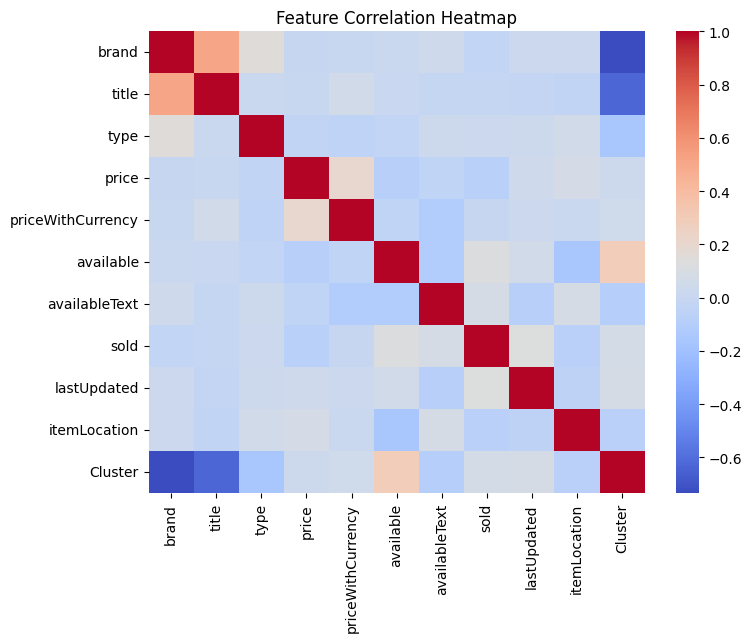

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


===== K-MEANS CLUSTERING =====
k=2, Silhouette Score=0.129
k=3, Silhouette Score=0.137
k=4, Silhouette Score=0.112
k=5, Silhouette Score=0.115
k=6, Silhouette Score=0.126
k=7, Silhouette Score=0.134
k=8, Silhouette Score=0.123


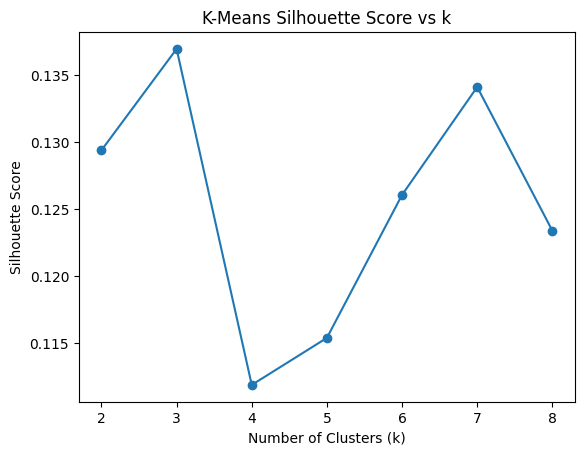


Best K Value based on Silhouette Score: 3


In [ ]:

results = []

print("\n===== K-MEANS CLUSTERING =====")
sil_scores = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f"k={k}, Silhouette Score={sil:.3f}")


plt.plot(range(2,9), sil_scores, marker='o')
plt.title("K-Means Silhouette Score vs k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

best_k = np.argmax(sil_scores) + 2
print(f"\nBest K Value based on Silhouette Score: {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)
results.append(["K-Means", kmeans_sil, kmeans_db])



===== HIERARCHICAL CLUSTERING =====


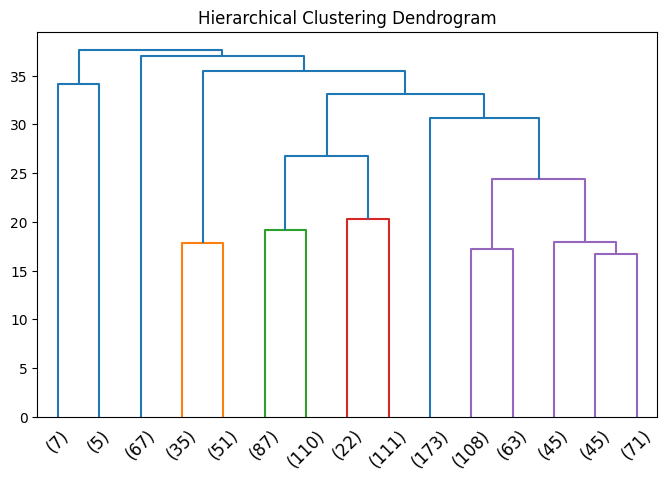

In [ ]:
print("\n===== HIERARCHICAL CLUSTERING =====")
hc = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
hc_labels = hc.fit_predict(X_scaled)
hc_sil = silhouette_score(X_scaled, hc_labels)
hc_db = davies_bouldin_score(X_scaled, hc_labels)
results.append(["Hierarchical", hc_sil, hc_db])

plt.figure(figsize=(8,5))
linked = linkage(X_scaled, 'ward')
dendrogram(linked, truncate_mode='lastp', p=15, leaf_rotation=45)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [ ]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)
mask = db_labels != -1
if len(set(db_labels)) > 1:
    db_sil = silhouette_score(X_scaled[mask], db_labels[mask])
    db_db = davies_bouldin_score(X_scaled[mask], db_labels[mask])
else:
    db_sil, db_db = np.nan, np.nan
results.append(["DBSCAN", db_sil, db_db])

result_df = pd.DataFrame(results, columns=["Model", "Silhouette", "Davies_Bouldin"])
print("\n===== MODEL COMPARISON =====\n", result_df)


===== MODEL COMPARISON =====
           Model  Silhouette  Davies_Bouldin
0       K-Means    0.136955        1.928129
1  Hierarchical    0.233535        1.511685
2        DBSCAN    0.079840        1.217893
3        DBSCAN    0.079840        1.217893
4        DBSCAN    0.079840        1.217893
5        DBSCAN    0.079840        1.217893


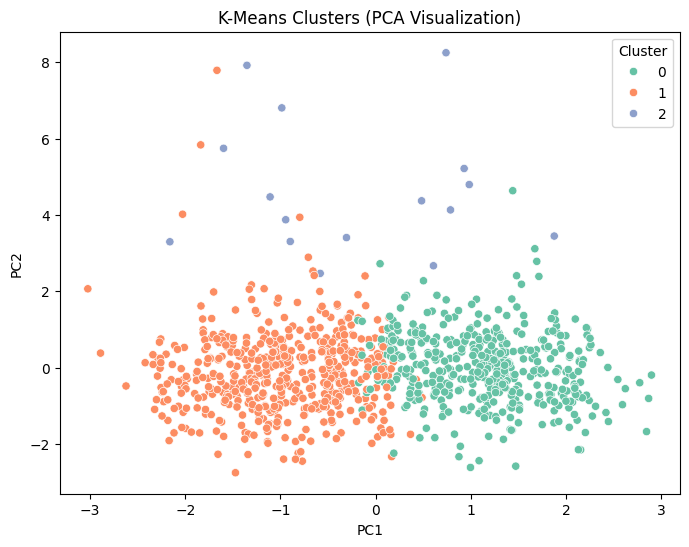

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["Cluster"] = kmeans_labels

plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=pca_df, palette="Set2")
plt.title("K-Means Clusters (PCA Visualization)")
plt.show()

In [ ]:
df["Cluster"] = kmeans_labels

# Numeric summaries per cluster
cluster_summary = df.groupby("Cluster")[num_cols].mean().round(2)
print("\n===== CLUSTER CHARACTERISTICS =====\n", cluster_summary)

# Count of perfumes in each cluster
cluster_counts = df["Cluster"].value_counts()
print("\nCluster Counts:\n", cluster_counts)


===== CLUSTER CHARACTERISTICS =====
           brand   title   type  price  priceWithCurrency  available  \
Cluster                                                               
0        186.14  687.97  30.99  44.52             331.00      14.09   
1         68.27  309.42  27.84  48.81             355.55      13.59   
2        130.62  468.06  28.19  25.76             279.88     402.81   

         availableText     sold  lastUpdated  itemLocation  
Cluster                                                     
0               404.92   580.09       470.66        115.41  
1               381.34   861.08       511.58        110.08  
2               169.19  2890.69       596.00         52.00  

Cluster Counts:
 Cluster
1    531
0    453
2     16
Name: count, dtype: int64


In [ ]:
df.to_csv("Fragrance_Clustered_Output.csv", index=False)
print("\n Clustered Dataset Saved: 'Fragrance_Clustered_Output.csv'")



 Clustered Dataset Saved: 'Fragrance_Clustered_Output.csv'


In [ ]:
best_model = result_df.loc[result_df["Silhouette"].idxmax(), "Model"]
print(f"\n Best Performing Model: {best_model}")
print(" Use this model for personalized fragrance grouping & marketing insights.")


 Best Performing Model: Hierarchical
 Use this model for personalized fragrance grouping & marketing insights.
